In [1]:
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import confusion_matrix


# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
#Import dataset
import pathlib
import os
import zipfile

# Spécifier le chemin du fichier zip à dézipper
fichier_zip = '/content/wetransfer_art_2023-11-19_2132.zip'

# Spécifier le répertoire de destination pour extraire les fichiers
destination = '/content/image'

# Ouvrir le fichier zip
with zipfile.ZipFile(fichier_zip, 'r') as zip_ref:
    # Extraire tous les fichiers vers le répertoire de destination
    zip_ref.extractall(destination)

print("Le dossier a été dézippé avec succès.")

Le dossier a été dézippé avec succès.


In [64]:
pictures = []
labels   = []

for dossier in ["prouvé", "random"]:
    dossier_complet = os.path.join('/content/image/ART', dossier)
    label = 1 if dossier == "prouvé" else 0

    for fichier in os.listdir(dossier_complet):
        chemin_image = os.path.join(dossier_complet, fichier)
        image = cv2.imread(chemin_image)

        if image is not None:
            # Redimensionnez l'image si nécessaire
            image = cv2.resize(image, (10, 10))
            image = image/255.0
            # Ajouter l'image et le label aux listes
            pictures.append(image)
            labels.append(label)

pictures = np.stack(pictures, axis=0)
#J'utilise pytorch -> tensor
pictures = torch.tensor(pictures)
print('picture shape :',pictures.shape)
labels = np.array(labels)
labels = torch.tensor(labels)
print('labels shape :',labels.shape)

picture shape : torch.Size([1917, 10, 10, 3])
labels shape : torch.Size([1917])


In [65]:
pictures_train, pictures_test, labels_train, labels_test = train_test_split(pictures, labels, test_size=0.2, random_state=42)

In [66]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, in_dim):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.in_dim = in_dim
        self.features = nn.Sequential(
            nn.Conv2d(self.in_dim, out_channels = 32, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding =0),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=32, out_channels = 64, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding=0),
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels=64, out_channels = 64, kernel_size = 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2, padding=0)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.reshape(bsize, -1)
        #print(output.shape)
        output = self.classifier(output) # we compute the output of the fc layers
        return output



In [67]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return {'image': image, 'label': label}



In [68]:
import torch.nn.functional as F


#criterion = F.binary_cross_entropy
model = ConvNet(3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
batch_size = 10

In [78]:
#pictures_train, pictures_test, labels_train, labels_test
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(pictures_train, labels_train)
train_dl = torch.utils.data.DataLoader(train_dataset,
                        batch_size, shuffle=True)

val_dataset = TensorDataset(pictures_test, labels_test)
val_dl = torch.utils.data.DataLoader(val_dataset,
                        batch_size, shuffle=True)

In [70]:
def training_dl(nb_epoch, model_dl, dataloader, optimizer, criterion):
  LOSS = []
  ACCURACY = []
  Y_esti_list = []


  for epoch in range(nb_epoch):
      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      for X_batch, Y_batch in dataloader:
          optimizer.zero_grad()
          X_batch = X_batch.float()
          X_batch = X_batch.permute(0, 3, 1, 2)
          prediction = model_dl(X_batch)

          # Calcul de la perte
          loss = criterion(prediction, Y_batch)
          loss.backward()
          total_loss += loss.item()
          optimizer.step()

          # Calcul de l'exactitude
          _, Y_esti = torch.max(prediction, 1)
          correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
          total_samples += len(Y_batch)

      # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
      average_loss = total_loss / len(dataloader)
      accuracy = correct_predictions / total_samples

      # Enregistrement des valeurs
      LOSS.append(average_loss)
      ACCURACY.append(accuracy)

      print(f'Epoch [{epoch + 1}/{nb_epoch}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


  return LOSS, ACCURACY, model_dl

In [86]:
def test_dl(nb_epoch, model_dl, dataloader, optimizer, criterion):
  LOSS = []
  ACCURACY = []
  Y_esti_list = []

  model_dl.eval()
  for epoch in range(1):
      total_loss = 0
      correct_predictions = 0
      total_samples = 0
      with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.float()
            X_batch = X_batch.permute(0, 3, 1, 2)
            prediction = model_dl(X_batch)

            # Calcul de la perte
            loss = criterion(prediction, Y_batch)

            total_loss += loss.item()

            # Calcul de l'exactitude
            _, Y_esti = torch.max(prediction, 1)
            correct_predictions += torch.sum(torch.eq(Y_esti, (Y_batch))).item()
            total_samples += len(Y_batch)

        # Calcul de la perte moyenne et de l'exactitude moyenne pour l'époque
        average_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_samples

        # Enregistrement des valeurs
        LOSS.append(average_loss)
        ACCURACY.append(accuracy)

      print(f'Résultat de l evaluation, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

  return LOSS, ACCURACY

In [72]:
nb_epoch = 150
LOSS_train, ACCURACY_train, model = training_dl(nb_epoch, model, train_dl, optimizer, criterion)


Epoch [1/150], Loss: 0.6745, Accuracy: 0.6236
Epoch [2/150], Loss: 0.6587, Accuracy: 0.6360
Epoch [3/150], Loss: 0.6617, Accuracy: 0.6360
Epoch [4/150], Loss: 0.6603, Accuracy: 0.6360
Epoch [5/150], Loss: 0.6586, Accuracy: 0.6360
Epoch [6/150], Loss: 0.6574, Accuracy: 0.6360
Epoch [7/150], Loss: 0.6560, Accuracy: 0.6360
Epoch [8/150], Loss: 0.6557, Accuracy: 0.6360
Epoch [9/150], Loss: 0.6523, Accuracy: 0.6360
Epoch [10/150], Loss: 0.6480, Accuracy: 0.6360
Epoch [11/150], Loss: 0.6410, Accuracy: 0.6360
Epoch [12/150], Loss: 0.6264, Accuracy: 0.6380
Epoch [13/150], Loss: 0.5987, Accuracy: 0.7156
Epoch [14/150], Loss: 0.5711, Accuracy: 0.7260
Epoch [15/150], Loss: 0.5587, Accuracy: 0.7397
Epoch [16/150], Loss: 0.5401, Accuracy: 0.7599
Epoch [17/150], Loss: 0.5376, Accuracy: 0.7632
Epoch [18/150], Loss: 0.5347, Accuracy: 0.7639
Epoch [19/150], Loss: 0.5203, Accuracy: 0.7880
Epoch [20/150], Loss: 0.5149, Accuracy: 0.7958
Epoch [21/150], Loss: 0.5187, Accuracy: 0.7841
Epoch [22/150], Loss: 

TypeError: ignored

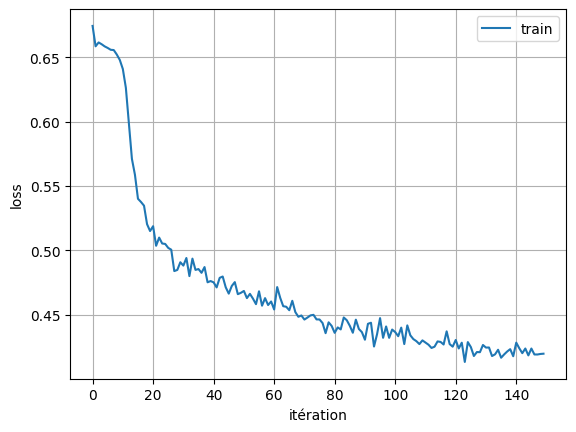

In [87]:
plt.figure()
plt.plot(range(nb_epoch), LOSS_train, label = "train")
plt.xlabel("itération")
plt.ylabel("loss")
plt.legend()
plt.grid()

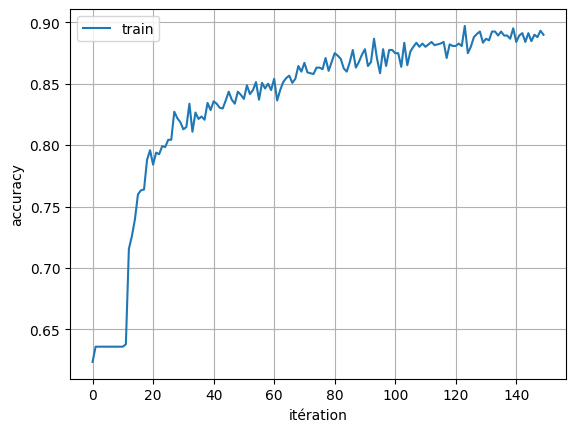

In [88]:
plt.figure()
plt.plot(range(nb_epoch), ACCURACY_train, label = "train")
plt.xlabel("itération")
plt.ylabel("accuracy")
plt.legend()
plt.grid()

In [89]:
LOSS_test, ACCURACY_test = test_dl(nb_epoch, model, val_dl, optimizer, criterion)

Résultat de l evaluation, Loss: 0.4393, Accuracy: 0.8620
